# Check GPU Type

In [1]:
!nvidia-smi
# !pip uninstall torchsummary
!pip install torchsummary

Wed May  1 01:08:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Get Data
Download the data directly from Kaggle


In [2]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/food11.zip"

In [3]:
! rm -r __MACOSX/

# Import Packages

In [4]:
# Import some useful packages for this homework
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.utils.prune as prune
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful
from torchvision.datasets import DatasetFolder, VisionDataset
from torchsummary import summary
from tqdm.auto import tqdm
import random
import pdb

# Configuration

In [29]:
cfg = {
    'dataset_root': './food11/',
    'save_dir': '/content/drive/MyDrive/',
    'exp_name': "medium_baseline_p",
    'batch_size': 64,
    'lr': 3e-4,
    'lr_step_size': 5,
    'lr_gamma':0.5,
    'seed': 20220013,
    'loss_fn_type': 'KD', # simple baseline: CE, medium baseline: KD. See the Knowledge_Distillation part for more information.
    'weight_decay': 1e-5,
    'grad_norm_max': 10,
    'n_epochs': 10, # train more steps to pass the medium baseline.
    'patience': 15,
    'quantization': False,
    'prune': True,
    'prune_times': 5,
    'prune_epoch': 6,
    'prune_ratio': 0.1,
    'pretrain': False,
    'pretrain_path': '/content/drive/MyDrive/medium_baseline_p/student_best_prune.ckpt',
    'pretrain_accuracy': 0.67
}

In [6]:
myseed = cfg['seed']  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
random.seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

save_path = os.path.join(cfg['save_dir'], cfg['exp_name']) # create saving directory
os.makedirs(save_path, exist_ok=True)

# define simple logging functionality
log_fw = open(f"{save_path}/log.txt", 'w') # open log file to save log outputs
def log(text):     # define a logging function to trace the training process
    print(text)
    log_fw.write(str(text)+'\n')
    log_fw.flush()

log(cfg)

{'dataset_root': './food11/', 'save_dir': '/content/drive/MyDrive/', 'exp_name': 'medium_baseline_p', 'batch_size': 64, 'lr': 0.0005, 'lr_step_size': 10, 'lr_gamma': 0.5, 'seed': 20220013, 'loss_fn_type': 'KD', 'weight_decay': 1e-05, 'grad_norm_max': 10, 'n_epochs': 20, 'patience': 15, 'quantization': False, 'prune': True, 'prune_times': 5, 'prune_epoch': 6, 'prune_ratio': 0.1, 'pretrain': False, 'pretrain_path': '/content/drive/MyDrive/medium_baseline_p/student_best_prune.ckpt', 'pretrain_accuracy': None}


# Transforms / Datasets / DataLoaders

In [7]:
# Transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# define training/testing transforms
test_tfm = transforms.Compose([
    # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_tfm = transforms.Compose([
    # add some useful transform or augmentation here, according to your experience in HW3.
    # transforms.Resize(256),  # You can change this
    # transforms.CenterCrop(224), # You can change this, but be aware of that the given teacher model's input size is 224.
    # The training input size of the provided teacher model is (3, 224, 224).
    # Thus, Input size other then 224 might hurt the performance. please be careful.
    # transforms.RandomHorizontalFlip(), # You can change this.
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(7, (0.1, 1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=(-0.05, 0.05)),
    transforms.ToTensor(),
    normalize,
])


In [8]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files

        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)

        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label

        return im,label

In [9]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./food11/training", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=cfg['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./food11/validation", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

# Visualize Dataset

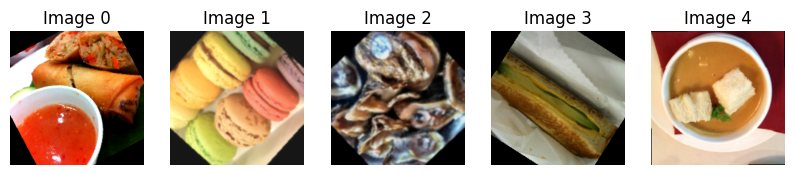

In [ ]:
import matplotlib.pyplot as plt

# train_set = FoodDataset("./food11/sample", tfm=train_tfm)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
imgs = np.zeros([5,3,224,224])
for batch in train_loader:
    img, labels = batch
    # print(img.shape)
    img = img.numpy()
    imgs = img[0:5]
    break

fig = plt.figure(figsize=(10, 3))
for i in range(5):
    fig.add_subplot(1, 5, i+1)
    show_img = np.zeros([imgs.shape[2], imgs.shape[3], 3])
    # mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    show_img[:, :, 0] = imgs[i][0, :, :] * 0.229 + 0.485
    show_img[:, :, 1] = imgs[i][1, :, :] * 0.224 + 0.456
    show_img[:, :, 2] = imgs[i][2, :, :] * 0.225 + 0.406
    plt.imshow(show_img)
    plt.axis('off')
    plt.title(f"Image {i}")
plt.show()

# Student Model

In [10]:
# Example implementation of Depthwise and Pointwise Convolution
def dwpw_conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels), #depthwise convolution
        nn.Conv2d(in_channels, out_channels, 1), # pointwise convolution
    )

class ResConv(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
        self.fadd = torch.nn.quantized.FloatFunctional()

    def forward(self, inputs):
        return self.fadd.add(self.module(inputs), inputs)

def res_conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    layer = nn.Sequential(
        ResConv(nn.Sequential(dwpw_conv(in_channels, in_channels, kernel_size, stride=stride, padding=padding),
                              nn.BatchNorm2d(in_channels),
                              nn.ReLU())),
        nn.Conv2d(in_channels, out_channels, 1), # pointwise convolution
        # ResConv(nn.Sequential(dwpw_conv(out_channels, out_channels, kernel_size, stride=stride, padding=padding),
        #                       nn.BatchNorm2d(out_channels),
        #                       nn.ReLU())),
    )
    return layer

class PruneResConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.dw_conv = nn.Conv2d(in_channels, in_channels, kernel_size,
                                 stride=stride, padding=padding, groups=in_channels)
        self.pw_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.nonlinear = nn.ReLU()
        self.out_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.fadd = torch.nn.quantized.FloatFunctional()
        self.mask = None

    def forward(self, inputs):
        x = self.dw_conv(inputs)
        x = self.pw_conv(x)
        x = self.bn(x)
        x = self.nonlinear(x)
        x = self.fadd.add(x, inputs)
        return self.out_conv(x)

    def prune_conv(self, in_mask, prune_ratio=0):
        in_channels = torch.sum(in_mask)
        to_prune_channels = int(self.out_channels * prune_ratio)
        out_channels = self.out_channels - to_prune_channels
        new_dw_conv = nn.Conv2d(in_channels, in_channels, self.kernel_size,
                                stride=self.stride, padding=self.padding, groups=in_channels)
        new_pw_conv = nn.Conv2d(in_channels, in_channels, 1)
        new_bn = nn.BatchNorm2d(in_channels)
        pre_out_conv = nn.Conv2d(in_channels, self.out_channels, 1)
        post_out_conv = nn.Conv2d(in_channels, out_channels, 1)

        new_dw_conv.weight.data = self.dw_conv.weight.data[in_mask]
        new_dw_conv.bias.data = self.dw_conv.bias.data[in_mask]
        new_pw_conv.weight.data = self.pw_conv.weight.data[:, in_mask, :, :][in_mask, :, :, :]
        new_pw_conv.bias.data = self.pw_conv.bias.data[in_mask]
        new_bn.running_mean.data = self.bn.running_mean.data[in_mask]
        new_bn.running_var.data = self.bn.running_var.data[in_mask]
        new_bn.weight.data = self.bn.weight.data[in_mask]
        new_bn.bias.data = self.bn.bias.data[in_mask]
        new_bn.eps = self.bn.eps
        pre_out_conv.weight.data = self.out_conv.weight.data[:, in_mask, :, :]
        pre_out_conv.bias= self.out_conv.bias

        prune.ln_structured(pre_out_conv, name="weight", amount=to_prune_channels, n=1, dim=0)
        mask = pre_out_conv.weight_mask.data[:, 0, 0, 0].bool()
        post_out_conv.weight.data = pre_out_conv.weight.data[mask, :, :, :]
        post_out_conv.bias.data = pre_out_conv.bias.data[mask]

        self.dw_conv = new_dw_conv
        self.pw_conv = new_pw_conv
        self.bn = new_bn
        self.out_conv = post_out_conv
        self.mask = mask

        self.in_channels = in_channels
        self.out_channels = out_channels
        print(f"Pruned, in_channels: {self.in_channels}, out_channels: {self.out_channels}")



In [11]:
class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------- TODO ----------
        # Modify your model architecture

        self.cnn = nn.Sequential(
          nn.Conv2d(3, 16, 3, stride=1, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),

          nn.Conv2d(16, 32, 3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2, 2, 0),

          # nn.Conv2d(4, 16, 3),
          # dwpw_conv(16, 32, 3, stride=1, padding=1),
          # nn.BatchNorm2d(32),
          # nn.ReLU(),
          res_conv(32, 64, 3, stride=1, padding=1),
          nn.MaxPool2d(2, 2, 0),

          # nn.Conv2d(16, 64, 3),
          # dwpw_conv(32, 64, 3, stride=1, padding=1),
          # nn.BatchNorm2d(64),
          # nn.ReLU(),
          # res_conv(64, 128, 3, stride=1, padding=1),
          PruneResConv(64, 120, 3, stride=1, padding=1),
          nn.MaxPool2d(2, 2, 0),

          # nn.Conv2d(64, 84, 3),
          # dwpw_conv(128, 128, 3, stride=1, padding=1),
          # nn.BatchNorm2d(128),
          # nn.ReLU(),
          # res_conv(128, 140, 3, stride=1, padding=1),
          PruneResConv(120, 180, 3, stride=1, padding=1),
          nn.MaxPool2d(2, 2, 0),

          # dwpw_conv(128, 224, 3, stride=1, padding=1),
          # nn.BatchNorm2d(224),
          # nn.ReLU(),
          PruneResConv(180, 180, 3, stride=1, padding=1),

          # Here we adopt Global Average Pooling for various input size.
          nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.fc = nn.Sequential(
          # nn.Dropout(0.2, inplace=True),
          # nn.Linear(128, 64),
          # nn.ReLU(inplace=True),
          nn.Linear(180, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

    def prune_model(self, ratio: float = 0):
        mask = None
        for name, module in self.cnn.named_modules():
            # print(f"Layer Name: {name}, Module Type: {type(module)}")
            if isinstance(module, PruneResConv):
                print(f"Pruning {name}, in_channels: {module.in_channels}")
                if mask is None:
                    mask = torch.ones(module.in_channels, dtype=torch.bool)
                module.prune_conv(mask, ratio)
                mask = module.mask

        new_fc = nn.Linear(int(torch.sum(mask)), int(self.fc[0].weight.shape[0]))
        new_fc.weight.data = self.fc[0].weight.data[:, mask]
        new_fc.bias.data = self.fc[0].bias.data
        self.fc[0] = new_fc

def get_student_model(): # This function should have no arguments so that we can get your student network by directly calling it.
    # you can modify or do anything here, just remember to return an nn.Module as your student network.
    student_model = StudentNet()
    return student_model

# End of definition of your student model and the get_student_model API
# Please copy-paste the whole code block, including the get_student_model function.

In [12]:
# DO NOT modify this block and please make sure that this block can run sucessfully.
student_model = get_student_model()
summary(student_model, (3, 224, 224), device='cpu')
print(student_model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           4,640
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]             320
            Conv2d-9         [-1, 32, 112, 112]           1,056
      BatchNorm2d-10         [-1, 32, 112, 112]              64
             ReLU-11         [-1, 32, 112, 112]               0
         Identity-12         [-1, 32, 112, 112]               0
          ResConv-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 64, 1

# Teacher Model

In [13]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
teacher_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
# print(model)
teacher_model.classifier =  nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(1280, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 11)
)
# summary(teacher_model, (3, 224, 224), device='cpu')

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 56.9MB/s]


# Training Teacher model

In [ ]:
# "cuda" only when GPUs are available.
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = Classifier().to(device)
teacher_model = teacher_model.to(device)

# The number of batch size.
batch_size = cfg['batch_size']

# The number of training epochs.
n_epochs = 6

# If no improvement in 'patience' epochs, early stop.
patience = 3

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    teacher_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = teacher_model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(teacher_model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)


    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    teacher_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = teacher_model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc and valid_acc > 0.86533:
        with open(f"./teacher_model_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./teacher_model_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc and valid_acc > 0.86533:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(teacher_model.state_dict(), f"teacher_model_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 001/006 ] loss = 0.35753, acc = 0.88081


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 001/006 ] loss = 0.47628, acc = 0.85558
[ Valid | 001/006 ] loss = 0.47628, acc = 0.85558


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 002/006 ] loss = 0.33395, acc = 0.88984


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 002/006 ] loss = 0.50144, acc = 0.83900
[ Valid | 002/006 ] loss = 0.50144, acc = 0.83900


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 003/006 ] loss = 0.32749, acc = 0.89145


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 003/006 ] loss = 0.49600, acc = 0.84786
[ Valid | 003/006 ] loss = 0.49600, acc = 0.84786


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 004/006 ] loss = 0.30225, acc = 0.89750


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 004/006 ] loss = 0.57171, acc = 0.83272
[ Valid | 004/006 ] loss = 0.57171, acc = 0.83272
No improvment 3 consecutive epochs, early stopping


# Test teacher network

In [14]:
# use pretrained teacher net
! cp /content/drive/MyDrive/Colab\ Notebooks/ML2023_NN_Compression/teacher_model_best.ckpt ./

In [15]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
test_set = FoodDataset("./food11/evaluation", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
teacher_model = teacher_model.to(device)
teacher_model.load_state_dict(torch.load("./teacher_model_best.ckpt", map_location=device))
teacher_model.eval()
with torch.no_grad():
    test_accs = []
    for imgs, labels in tqdm(test_loader):
        test_pred = teacher_model(imgs.to(device))
        # test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        acc = (test_pred.argmax(dim=-1) == labels.to(device)).float().mean()
        test_accs.append(acc)
    test_acc = sum(test_accs) / len(test_accs)

    # Print the information.
    print(f"[ Test ] acc = {test_acc:.5f}")

  0%|          | 0/53 [00:00<?, ?it/s]

[ Test ] acc = 0.88344


# Loss function (distillation loss)

In [16]:
# Implement the loss function with KL divergence loss for knowledge distillation.
def loss_fn_kd(student_logits, labels, teacher_logits, alpha=0.5, temperature=1.0):
    # ------------TODO-------------
    # Refer to the above formula and finish the loss function for knowkedge distillation using KL divergence loss and CE loss.
    # If you have no idea, please take a look at the provided useful link above.
    loss_ce = F.cross_entropy(student_logits, labels)
    student_logits = student_logits / temperature
    teacher_logits = teacher_logits / temperature
    loss_kl = F.kl_div(F.log_softmax(student_logits, dim=-1),
                       F.softmax(teacher_logits, dim=-1),
                       reduction='batchmean')
    loss = alpha * loss_ce + (1 - alpha) * (temperature**2) * loss_kl
    # print(loss_ce, loss_kl)
    return loss

# Student network trainer



In [17]:
def trainer(cfg, train_loader, valid_loader, student_model, teacher_model=None, save_ckpt_path=None):

    # loading pretrain model
    if cfg['pretrain']:
        print(f"Loading model from {cfg['pretrain_path']}..")
        student_model.load_state_dict(torch.load(cfg['pretrain_path'], map_location='cpu'))

    # choose the loss function by the config
    if cfg['loss_fn_type'] == 'CE':
        # For the classification task, we use cross-entropy as the default loss function.
        loss_fn = nn.CrossEntropyLoss() # loss function for simple baseline.

    if cfg['loss_fn_type'] == 'KD': # KD stands for knowledge distillation
        loss_fn = loss_fn_kd # implement loss_fn_kd for the report question and the medium baseline.

    # "cuda" only when GPUs are available.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # log configuration
    log(f"n_epochs: {cfg['n_epochs']}, patience:{cfg['patience']}, device: {device}")
    log(f"pretrain_accuracy: {cfg['pretrain_accuracy']}, loss_fn_type: {cfg['loss_fn_type']}")

    # Initialize a model, and put it on the device specified.
    student_model.to(device)
    if teacher_model is not None:
        teacher_model.to(device)
        teacher_model.eval()

    # Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
    optimizer = torch.optim.Adam(student_model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg['lr_step_size'], gamma=cfg['lr_gamma'])
    log(f"optimizer: {optimizer}")
    log(f"scheduler: {scheduler}")

    # Initialize trackers, these are not parameters and should not be changed
    stale = 0
    best_acc = 0 if cfg['pretrain_accuracy'] is None else cfg['pretrain_accuracy']
    # Iterate over epochs.
    for epoch in range(cfg['n_epochs']):

        # ---------- Pruning -----------
        # Prune the network and retrain
        if cfg['prune'] and (epoch % cfg['prune_epoch']) == 0:
            student_model.prune_model(ratio=cfg['prune_ratio'])
            summary(student_model, (3, 224, 224), device='cuda')
            stale = 0
            best_acc = 0

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        student_model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []
        train_lens = []

        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            #imgs = imgs.half()
            #print(imgs.shape,labels.shape)

            # Forward the data. (Make sure data and model are on the same device.)
            logits = student_model(imgs)
            if teacher_model is not None:
                with torch.no_grad():
                    teacher_logits = teacher_model(imgs)
                loss = loss_fn(logits, labels, teacher_logits)
            else:
                loss = loss_fn(logits, labels)

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=cfg['grad_norm_max'])

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels).float().sum()

            # Record the loss and accuracy.
            train_batch_len = len(imgs)
            train_loss.append(loss.item() * train_batch_len)
            train_accs.append(acc)
            train_lens.append(train_batch_len)

        train_loss = sum(train_loss) / sum(train_lens)
        train_acc = sum(train_accs) / sum(train_lens)

        # Print the information.
        log(f"[ Train | {epoch + 1:03d}/{cfg['n_epochs']:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
        scheduler.step()

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        student_model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []
        valid_lens = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = student_model(imgs)
                if teacher_model is not None:
                    teacher_logits = teacher_model(imgs)
                    loss = loss_fn(logits, labels, teacher_logits)
                else:
                    loss = loss_fn(logits, labels)

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels).float().sum()

            # Record the loss and accuracy.
            batch_len = len(imgs)
            valid_loss.append(loss.item() * batch_len)
            valid_accs.append(acc)
            valid_lens.append(batch_len)
            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / sum(valid_lens)
        valid_acc = sum(valid_accs) / sum(valid_lens)

        # update logs
        if valid_acc > best_acc:
            log(f"[ Valid | {epoch + 1:03d}/{cfg['n_epochs']:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
        else:
            log(f"[ Valid | {epoch + 1:03d}/{cfg['n_epochs']:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        # save models
        if valid_acc > best_acc:
            log(f"Best model found at epoch {epoch+1}, saving model to {save_ckpt_path}")
            if save_ckpt_path:
                torch.save(student_model.state_dict(), f"{save_ckpt_path}") # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if stale > cfg['patience']:
                log(f"No improvment {cfg['patience']} consecutive epochs, early stopping")
                break

    log("Finish training")
    # log_fw.close()

# Student network tester


In [18]:
def tester(cfg, student_model, pruned=False, quantized=False, load_model_path=None):
    torch.cuda.empty_cache()
    device = "cuda" if (torch.cuda.is_available() and not cfg['quantization']) else "cpu"
    if device == "cuda":
        torch.cuda.empty_cache()

    if cfg['prune'] and not pruned:
        for _ in range(cfg['prune_times']):
            student_model.prune_model(cfg['prune_ratio'])
        summary(student_model, (3, 224, 224), device='cpu')

    if cfg['quantization'] and not quantized:
        student_model.qconfig = torch.quantization.get_default_qconfig("x86")
        student_model = torch.quantization.prepare(student_model, inplace=False)
        student_model = torch.quantization.convert(student_model, inplace=False)

    if load_model_path:
        student_model.load_state_dict(torch.load(load_model_path, map_location=device))

    print(student_model)

    # Construct test datasets.
    test_set = FoodDataset("./food11/evaluation", tfm=test_tfm)
    test_loader = DataLoader(test_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

    # Test the model.
    student_model.eval()
    student_model.to(device)
    with torch.no_grad():
        test_accs = []
        for imgs, labels in tqdm(test_loader):
            test_pred = student_model(imgs.to(device))
            # print(test_pred.data[0])
            # test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
            acc = (test_pred.argmax(dim=-1) == labels.to(device)).float().mean()
            test_accs.append(acc)
        test_acc = sum(test_accs) / len(test_accs)

        # Print the information.
        print(f"[ Test ] acc = {test_acc:.5f}")

# Train student network

In [ ]:
trainer(cfg, train_loader, valid_loader, student_model, teacher_model,
        save_ckpt_path=f"{save_path}/student_best.ckpt")

# Test student network

In [ ]:
tester(cfg, student_model, load_model_path=f"{save_path}/student_best.ckpt")

# Iterative pruning
- https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#iterative-pruning
- https://pytorch.org/docs/stable/_modules/torch/nn/utils/prune.html#ln_structured
- https://stackoverflow.com/questions/73103144/how-to-fine-tune-the-pruned-model-in-pytorch
- https://github.com/DingXiaoH/RepVGG/blob/main/repvggplus.py#L78

In [ ]:
cfg['prune'] = True
cfg['lr'] = 3e-4
cfg['lr_step_size'] = cfg['prune_epoch'] * cfg['prune_times']  # disable lr decay
cfg['n_epochs'] = cfg['prune_epoch'] * cfg['prune_times']
cfg['pretrain'] = True
cfg['pretrain_path'] = f"{save_path}/student_best.ckpt"
cfg['pretrain_accuracy'] = None
student_model = get_student_model()
print(cfg)

{'dataset_root': './food11/', 'save_dir': '/content/drive/MyDrive/', 'exp_name': 'medium_baseline_p', 'batch_size': 64, 'lr': 0.0004, 'lr_step_size': 6, 'lr_gamma': 0.5, 'seed': 20220013, 'loss_fn_type': 'KD', 'weight_decay': 1e-05, 'grad_norm_max': 10, 'n_epochs': 15, 'patience': 15, 'quantization': False, 'prune': True, 'prune_times': 1, 'prune_epoch': 15, 'prune_ratio': 0.1, 'pretrain': False, 'pretrain_path': '/content/drive/MyDrive/medium_baseline_p/student_best.ckpt', 'pretrain_accuracy': None}


In [23]:
trainer(cfg, train_loader, valid_loader, student_model, teacher_model,
        save_ckpt_path=f"{save_path}/student_best_prune.ckpt")

n_epochs: 10, patience:15, device: cuda, loss_fn_type: KD
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_decay: 1e-05
)
scheduler: <torch.optim.lr_scheduler.StepLR object at 0x79cac01c3670>


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 001/010 ] loss = 0.98074, acc = 0.63095


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 001/010 ] loss = 0.91484, acc = 0.64840


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 002/010 ] loss = 0.89606, acc = 0.66004


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 002/010 ] loss = 0.89741, acc = 0.66006


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 003/010 ] loss = 0.87212, acc = 0.65660


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 003/010 ] loss = 0.88636, acc = 0.67609 -> best
Best model found at epoch 3, saving model to /content/drive/MyDrive/medium_baseline_p/student_best_prune.ckpt


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 004/010 ] loss = 0.85259, acc = 0.66957


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 004/010 ] loss = 0.87094, acc = 0.67318


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 005/010 ] loss = 0.83587, acc = 0.67059


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 005/010 ] loss = 0.83425, acc = 0.68134 -> best
Best model found at epoch 5, saving model to /content/drive/MyDrive/medium_baseline_p/student_best_prune.ckpt


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 006/010 ] loss = 0.80156, acc = 0.68792


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 006/010 ] loss = 0.81090, acc = 0.68746 -> best
Best model found at epoch 6, saving model to /content/drive/MyDrive/medium_baseline_p/student_best_prune.ckpt


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 007/010 ] loss = 0.78660, acc = 0.69724


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 007/010 ] loss = 0.79807, acc = 0.69155 -> best
Best model found at epoch 7, saving model to /content/drive/MyDrive/medium_baseline_p/student_best_prune.ckpt


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 008/010 ] loss = 0.77903, acc = 0.69663


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 008/010 ] loss = 0.81052, acc = 0.69125


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 009/010 ] loss = 0.77776, acc = 0.69917


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 009/010 ] loss = 0.76559, acc = 0.70379 -> best
Best model found at epoch 9, saving model to /content/drive/MyDrive/medium_baseline_p/student_best_prune.ckpt


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 010/010 ] loss = 0.77718, acc = 0.69329


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 010/010 ] loss = 0.85116, acc = 0.68076
Finish training


In [26]:
student_model = get_student_model()
tester(cfg, student_model, load_model_path=f"{save_path}/student_best_prune.ckpt")

Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 108
Pruning 11, in_channels: 120
Pruned, in_channels: 108, out_channels: 162
Pruning 13, in_channels: 180
Pruned, in_channels: 162, out_channels: 162
Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 98
Pruning 11, in_channels: 108
Pruned, in_channels: 98, out_channels: 146
Pruning 13, in_channels: 162
Pruned, in_channels: 146, out_channels: 146
Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 89
Pruning 11, in_channels: 98
Pruned, in_channels: 89, out_channels: 132
Pruning 13, in_channels: 146
Pruned, in_channels: 132, out_channels: 132
Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 81
Pruning 11, in_channels: 89
Pruned, in_channels: 81, out_channels: 119
Pruning 13, in_channels: 132
Pruned, in_channels: 119, out_channels: 119
Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 73
Pruning 11, in_channels: 81
Pruned, in_channels: 73, out_channels: 108
Prun

  0%|          | 0/53 [00:00<?, ?it/s]

[ Test ] acc = 0.72049


# Prepare to Quantize Student Model
Reference:
- https://pytorch.org/blog/quantization-in-practice/#quantization-aware-training-qat
- https://imprld01.github.io/blogg/2021/12/10/note_of_quantization_aware_training_in_pytorch/
- https://zhuanlan.zhihu.com/p/299108528

In [48]:
cfg['quantization'] = True
# cfg['prune'] = True

student_model = get_student_model()
if cfg['prune']:
    for _ in range(cfg['prune_times']):
        student_model.prune_model(cfg['prune_ratio'])
    student_model.load_state_dict(torch.load(f"{save_path}/student_best_prune.ckpt", map_location='cpu'))
else:
    student_model.load_state_dict(torch.load(f"{save_path}/student_best.ckpt", map_location='cpu'))
student_model.eval()

"""Fuse modules"""
# check layer name to fuse modules
# for name, module in student_model.named_modules():
#     print(name, module)
student_model = torch.quantization.fuse_modules(student_model, ['cnn.0','cnn.1','cnn.2'], inplace=False)
student_model = torch.quantization.fuse_modules(student_model, ['cnn.3','cnn.4','cnn.5'], inplace=False)
for layer_idx in [7]:
  student_model = torch.quantization.fuse_modules(student_model, [f'cnn.{layer_idx}.0.module.0.1',
                                                                   f'cnn.{layer_idx}.0.module.1',
                                                                   f'cnn.{layer_idx}.0.module.2'], inplace=False)
for layer_idx in [9, 11, 13]:
  student_model = torch.quantization.fuse_modules(student_model, [f'cnn.{layer_idx}.pw_conv',
                                                                   f'cnn.{layer_idx}.bn',
                                                                   f'cnn.{layer_idx}.nonlinear'], inplace=False)

"""Insert stubs"""
student_model.cnn = nn.Sequential(torch.quantization.QuantStub(),
                                  *student_model.cnn,
                                  torch.quantization.DeQuantStub())
student_model.fc = nn.Sequential(torch.quantization.QuantStub(),
                                  *student_model.fc,
                                  torch.quantization.DeQuantStub())
student_model.to('cpu').eval()
# summary(student_model, (3, 224, 224), device='cpu')
print(student_model)

Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 108
Pruning 11, in_channels: 120
Pruned, in_channels: 108, out_channels: 162
Pruning 13, in_channels: 180
Pruned, in_channels: 162, out_channels: 162
Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 98
Pruning 11, in_channels: 108
Pruned, in_channels: 98, out_channels: 146
Pruning 13, in_channels: 162
Pruned, in_channels: 146, out_channels: 146
Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 89
Pruning 11, in_channels: 98
Pruned, in_channels: 89, out_channels: 132
Pruning 13, in_channels: 146
Pruned, in_channels: 132, out_channels: 132
Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 81
Pruning 11, in_channels: 89
Pruned, in_channels: 81, out_channels: 119
Pruning 13, in_channels: 132
Pruned, in_channels: 119, out_channels: 119
Pruning 9, in_channels: 64
Pruned, in_channels: 64, out_channels: 73
Pruning 11, in_channels: 81
Pruned, in_channels: 73, out_channels: 108
Prun

# Try Static Quantization first

In [33]:
student_model.qconfig = torch.quantization.get_default_qconfig("x86")
student_model = torch.quantization.prepare(student_model, inplace=False)
# print(student_model)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [34]:
# calibrate model
for imgs, _ in tqdm(test_loader):
        _ = student_model(imgs.to('cpu'))
# print(student_model)

  0%|          | 0/53 [00:00<?, ?it/s]

In [35]:
student_model = torch.quantization.convert(student_model, inplace=False)

In [36]:
tester(cfg, student_model, pruned=cfg['prune'], quantized=True)

StudentNet(
  (cnn): Sequential(
    (0): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
    (1): QuantizedConvReLU2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.07096762210130692, zero_point=0, padding=(1, 1))
    (2): Identity()
    (3): Identity()
    (4): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.045442815870046616, zero_point=0, padding=(1, 1))
    (5): Identity()
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): ResConv(
        (module): Sequential(
          (0): Sequential(
            (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.05895957723259926, zero_point=63, padding=(1, 1), groups=32)
            (1): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.05037466436624527, zero_point=0)
          )
          (1): Identity()
          (2): Identity()
        )
        (fadd): QFun

  0%|          | 0/53 [00:00<?, ?it/s]

[ Test ] acc = 0.71558


# Prepare QAT (Quantized Aware Training)

In [50]:
student_model.train()
student_model.qconfig = torch.quantization.get_default_qconfig("x86")
student_model = torch.quantization.prepare_qat(student_model, inplace=False)  # Don't use inplace, ref:https://imprld01.github.io/blogg/2021/12/10/note_of_quantization_aware_training_in_pytorch/
# summary(student_model, (3, 224, 224), device='cpu')
# print(student_model)

In [51]:
cfg['lr'] = 3e-4
cfg['n_epochs'] = 10
cfg['lr_step_size'] = 5
# cfg['pretrain_accuracy'] = 0.72
# student_model.load_state_dict(torch.load(f"{save_path}/student_best_prune_quant.ckpt", map_location='cpu'))

temp = cfg['prune']
cfg['prune'] = False  # disable pruning
trainer(cfg, train_loader, valid_loader, student_model, teacher_model,
        save_ckpt_path=f"{save_path}/student_best_prune_quant.ckpt")
cfg['prune'] = temp  # resume pruning status

n_epochs: 10, patience:15, device: cuda, loss_fn_type: KD
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_decay: 1e-05
)
scheduler: <torch.optim.lr_scheduler.StepLR object at 0x79caa15a1600>


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 001/010 ] loss = 0.76706, acc = 0.69420


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 001/010 ] loss = 0.81114, acc = 0.71283


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 002/010 ] loss = 0.75359, acc = 0.70180


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 002/010 ] loss = 0.79598, acc = 0.71195


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 003/010 ] loss = 0.75327, acc = 0.70201


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 003/010 ] loss = 0.75600, acc = 0.71166


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 004/010 ] loss = 0.75068, acc = 0.70555


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 004/010 ] loss = 0.76272, acc = 0.70845


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 005/010 ] loss = 0.75416, acc = 0.70434


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 005/010 ] loss = 0.81700, acc = 0.69329


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 006/010 ] loss = 0.71331, acc = 0.71893


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 006/010 ] loss = 0.76973, acc = 0.71224


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 007/010 ] loss = 0.71254, acc = 0.71376


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 007/010 ] loss = 0.78911, acc = 0.70350


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 008/010 ] loss = 0.70919, acc = 0.72106


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 008/010 ] loss = 0.75313, acc = 0.72041 -> best
Best model found at epoch 8, saving model to /content/drive/MyDrive/medium_baseline_p/student_best_prune_quant.ckpt


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 009/010 ] loss = 0.70757, acc = 0.72248


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 009/010 ] loss = 0.77733, acc = 0.70991


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 010/010 ] loss = 0.71457, acc = 0.71660


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 010/010 ] loss = 0.76063, acc = 0.71808
Finish training


# Save Quantized Network

In [52]:
if cfg['quantization']:
    student_model.eval()
    if cfg['prune']:
        student_model.load_state_dict(torch.load(f"{save_path}/student_best_prune_quant.ckpt", map_location=device))
    else:
        student_model.load_state_dict(torch.load(f"{save_path}/student_best_quant.ckpt", map_location=device))
    student_model.to('cpu')
    student_model = torch.quantization.convert(student_model, inplace=False)
    if cfg['prune']:
        torch.save(student_model.state_dict(), f"{save_path}/student_best_prune_quant_convert.ckpt")
    else:
        torch.save(student_model.state_dict(), f"{save_path}/student_best_quant_convert.ckpt")

# Test Quantized Network

In [53]:
tester(cfg, student_model, pruned=cfg['prune'], quantized=True)

StudentNet(
  (cnn): Sequential(
    (0): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
    (1): QuantizedConvReLU2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.09459114819765091, zero_point=0, padding=(1, 1))
    (2): Identity()
    (3): Identity()
    (4): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.0600995235145092, zero_point=0, padding=(1, 1))
    (5): Identity()
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): ResConv(
        (module): Sequential(
          (0): Sequential(
            (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.07550002634525299, zero_point=60, padding=(1, 1), groups=32)
            (1): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.06590207666158676, zero_point=0)
          )
          (1): Identity()
          (2): Identity()
        )
        (fadd): QFunct

  0%|          | 0/53 [00:00<?, ?it/s]

[ Test ] acc = 0.73483


# Debug Scripts

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
student_model.cnn.register_forward_hook(get_activation('cnn'))
student_model.cnn[7].register_forward_hook(get_activation('cnn7'))
student_model.cnn[9].pw_conv.register_forward_hook(get_activation('cnn9_pw'))
student_model.cnn[9].bn.register_forward_hook(get_activation('cnn9_bn'))
student_model.cnn[9].out_conv.register_forward_hook(get_activation('cnn9_out'))
student_model.cnn[9].register_forward_hook(get_activation('cnn9'))

In [ ]:
print(activation['cnn'].shape)
print(activation['cnn7'][0,:,0,0])
print(activation['cnn9_pw'][0,:,0,0])
print(activation['cnn9_bn'][0,:,0,0])
print(activation['cnn9_out'][0,:,0,0])
print(activation['cnn9'][0,:,0,0])

In [ ]:
print(student_model.cnn[9].dw_conv.weight.data.shape)
print(student_model.cnn[9].dw_conv.weight.data[0, 0, :, :])
print(student_model.cnn[9].pw_conv.weight.data[0, 0, :, :])
print(student_model.cnn[9].out_conv.weight.data[0, 0, :, :])
print(student_model.cnn[9].dw_conv.bias.data[0])
print(student_model.cnn[9].pw_conv.bias.data[0])
print(student_model.cnn[9].out_conv.bias.data[0])
print(student_model.cnn[11].dw_conv.weight.data[0, 0, :, :])
print(student_model.cnn[11].pw_conv.weight.data[0, 0, :, :])
print(student_model.cnn[11].out_conv.weight.data[0, 0, :, :])
print(student_model.fc[0].weight.data[0, :])
print(student_model.fc[0].bias.data[:])
# print(torch.int_repr(student_model.cnn[1].weight()[0]).numpy())